In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

# Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

# Cross-Validation
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Prediction Scoring
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from statistics import mean
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Ignore warnings
import warnings
warnings.simplefilter('ignore')  

### Loading the test group for prediction

In [2]:
# Load Features created in StartFromScratch.ipynb
df = pd.read_csv('Final_Features_test.csv')

# # Drop participant name column because its not a feature
# df = df.drop('Participant name', axis=1)

# scaler = MinMaxScaler()
scaler = StandardScaler()

columns = list(df.columns)
columns.pop(0)
columns.pop(-1)
columns
df[columns] = scaler.fit_transform(df[columns])

### Categorizing our label
We are passing our label from a continuous to a discrete variable for a better __interpretation__ of the results and for the __simplicity__ of the predictions. We use the `pd.cut` function from pandas to create the bins and the respective label. In __Table 1__, we explain the process done.

In [3]:
# Discretizing my label/target
df['Empathy Score'] = pd.cut(df["Empathy Score"],
       bins=[80, 100, 110, 120, 130], 
       labels=[0, 1, 2, 3])

### <center> Table 1
| Empathy Range | Class | Label |
| :-: | :-: | :-: |
| <100 | Bad | 0 |
| 100-110 | Average | 1 |
| 110-120 | Good | 2 |
| >120 | Outstanding | 3 |

In [4]:
# Print DataFrame to see the results
df.head()

,Participant name,Mean Pupil diameter left,Std Pupil diameter left,Mean Pupil diameter right,Std Pupil diameter right,Num. of Fixations,Num. of Saccades,Num. of Unclassified,Recording duration (s),Mean Gaze event duration (s),Mean Fixation point X,Std Fixation point X,Mean Fixation point Y,Std Fixation point Y,Mean Gaze point X,Std Gaze point X,Mean Gaze point Y,Std Gaze point Y,Empathy Score
0,1.0,-0.089633,-0.814297,-0.196801,-0.876958,-0.098426,0.379303,-0.355026,-0.204618,-0.293486,1.662709,0.222486,-1.385322,-0.507767,1.866861,0.241699,-1.953166,-0.962940,3
1,1.0,-0.204996,-0.575084,-0.247813,-0.750402,-0.123609,0.038046,-0.614439,-0.413981,-0.315063,0.822417,1.022072,-1.011522,-0.429986,0.872312,1.171768,-1.211816,-1.184586,3
2,1.0,-0.162118,-1.071167,-0.142893,-1.213951,-0.474775,-0.019179,-0.614439,-0.615296,-0.421633,0.638070,0.134267,-0.326136,-0.123241,0.638859,0.031482,-0.480517,-0.398963,3
3,1.0,-0.251455,-0.969113,-0.234711,-1.115633,0.374458,0.709393,-0.370985,0.221591,-0.388220,0.550088,-0.864774,-0.419745,-0.033322,0.650658,-1.107551,-0.456417,-0.585927,3
4,1.0,-0.277955,-0.826529,-0.230868,-1.018470,-0.255401,0.046421,-0.564525,-0.453132,-0.308629,0.921692,0.202833,-0.267798,-0.243033,1.071226,0.286408,-0.341328,-0.583934,3


### Split data using StratifiedKFold
We are splitting our training and testing data using Group KFolds because of the nature of our labels, in essence we have a bunch of rows that that share the same label so we dont want any leakage of data from the testing data to the training data. We use this method instead of GroupKFolds because we found a bug will trying to do hyperparameter tuning. For more information: https://github.com/scikit-learn/scikit-learn/issues/22256

In [5]:
# Code to split data using StratifiedKFolds
X = df.drop(['Participant name','Empathy Score'], axis=1)
y = df['Empathy Score']
gps = df['Participant name']
cv = StratifiedKFold(5)

In [6]:
for train_index, test_index in cv.split(X, y, groups=gps):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(289, 17)
(72, 17)
(289,)
(72,)


## Classification models - test

In [7]:
# CODE FROM: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

# TRY RFE for features with SGDC
min_features_to_select = 1  # Minimum number of features to consider
clf = SGDClassifier(random_state=13)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 5


In [8]:
print(rfecv.ranking_)
print(rfecv.feature_names_in_)

[ 1  1  1  1  7 11  9 13 12 10  2  6  4  8  1  5  3]
['Mean Pupil diameter left' 'Std Pupil diameter left'
 'Mean Pupil diameter right' 'Std Pupil diameter right'
 'Num. of Fixations' 'Num. of Saccades' 'Num. of Unclassified'
 'Recording duration (s)' 'Mean Gaze event duration (s)'
 'Mean Fixation point X' 'Std Fixation point X' 'Mean Fixation point Y'
 'Std Fixation point Y' 'Mean Gaze point X' 'Std Gaze point X'
 'Mean Gaze point Y' 'Std Gaze point Y']


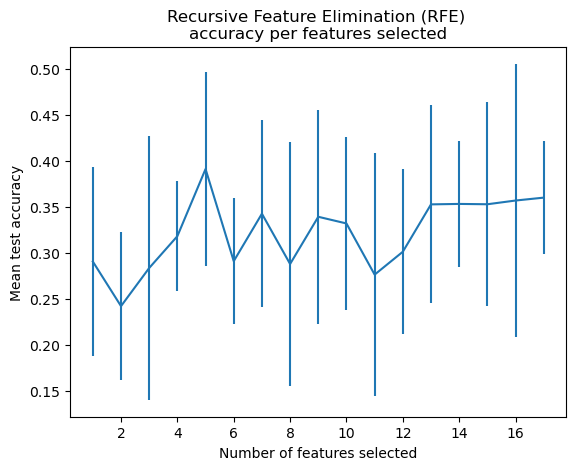

In [9]:
# CODE FROM: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination (RFE) \naccuracy per features selected")
plt.show()

### Results
After recognizing the best features for the predictor, we extract the accuracy of the estimator.

In [10]:
y_pred = rfecv.cv_results_["mean_test_score"].max()
y_pred_std = rfecv.cv_results_["std_test_score"][rfecv.cv_results_["mean_test_score"].argmax()]

print('Accuracy: %.2f +/- %.2f' % ((y_pred),y_pred_std))

Accuracy: 0.39 +/- 0.11
